# Analiza filmu na potrzeby działu autopromocji. Wsparcie przygotowania promocji antenowej.

W tym notatniku wykorzystam zestaw danych w postaci listy dialogowej (scenariusza filmu), aby eksplorować postacie z danego filmu. Chciałbym aby notatnik ten wspomagał proces tworzenia filmów promocyjnch na potrzeby telewizji. Skorzystam z kilku metod, w tym analizy nastrojów i emocji.


In [4]:
# Importujemy biblioteki

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

import spacy
from spacy import displacy

from keras import models
from keras import layers
import keras
from keras import optimizers
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding

############################################################################################################################################

## Importujemy dane

https://www.kaggle.com/datasets/matiaswargelin/pulp-fiction-script-dialogue

In [5]:
title = pd.read_csv('/pulp_fiction_dialogue.csv',encoding='cp1252')

In [6]:
column_names = title.columns.tolist()

# Print nazw kolumn
print(column_names)

['Line number', 'Character (in script)', 'Character (actual)', 'Off screen', 'Voice-over', 'Place', 'Time', 'Line', 'Word count']


In [7]:
# Zmieniamy nazwy kolumn 
title.rename(columns={'Character (in script)': 'character_in_script', 'Character (actual)': 'Character_name'}, inplace=True)

In [8]:
title.head(1800)

,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18
...,...,...,...,...,...,...,...,...,...
1178,1179,Pumpkin,Pumpkin,False,False,int. coffee shop,morning,Not regularly.,2
1179,1180,Jules,Jules,False,False,int. coffee shop,morning,There's a passage I got memorized. Ezekiel 25:...,242
1180,1181,Jules,Jules,False,False,int. coffee shop,morning,It's cold.,2
1181,1182,Vincent,Vincent,False,False,int. coffee shop,morning,I think we oughta leave now.,6


Jak widzimy powyżej naszed dane składają się z kilku elementów jak numer dialogu, sam dialog, nazwę postaci, czy dana postać jest z off-u, czy jest voice-overem. Widzimy także gdzie akcja miała miejsce i jaka była pora dnia.

## Określmy znaczenia postaci na podstawie liczby linijek i słów dialogu

In [9]:
title['Character_name'].value_counts()

Vincent                   259
Jules                     209
Butch                     135
Fabienne                   90
Mia                        81
Pumpkin                    62
The Wolf                   54
Lance                      50
Honey Bunny                39
Brett                      27
Jimmie                     26
Jody                       21
Maynard                    21
Marsellus                  20
Esmarelda                  20
English Dave               11
Zed                        10
Ed Sullivan                 7
Buddy                       6
Manager                     5
Raquel                      4
Mother                      3
Sportscaster #1             3
Sportscaster #2             2
Capt. Koons                 2
Waitress                    2
Marvin                      2
Gawker #2                   2
Fourth man                  2
The Gimp                    1
Klondike                    1
Roger                       1
Trudi                       1
Gawker #1 

Jak widzimy powyżej TOP 3 postacie to Vincent, Jules i Butch.

Zobaczmy poniżej jak to wygląda w formie wizualnej - TOP 20.

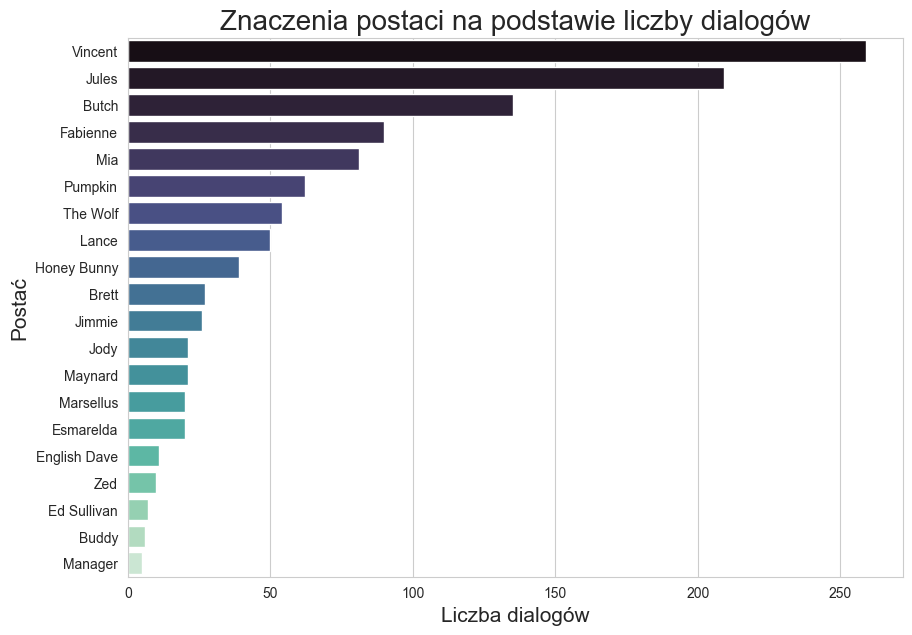

In [10]:
sns.set_style('whitegrid')

plt.figure(figsize=(10,7))
sns.countplot(y='Character_name', data=title, palette="mako", order=title.Character_name.value_counts().iloc[:20].index)
plt.xlabel('Liczba dialogów', fontsize=15)
plt.ylabel('Postać', fontsize=15)
plt.title('Znaczenia postaci na podstawie liczby dialogów', fontsize=20)

plt.show()

In [11]:
title.Line

0       No, forget it, it's too risky. I'm through doi...
1       You always say that, the same thing every time...
2       I know that's what I always say. I'm always ri...
3           â€“ but you forget about it in a day or two -
4       â€“ yeah, well, the days of me forgittin' are ...
                              ...                        
1178                                       Not regularly.
1179    There's a passage I got memorized. Ezekiel 25:...
1180                                           It's cold.
1181                         I think we oughta leave now.
1182                         That's probably a good idea.
Name: Line, Length: 1183, dtype: object

In [12]:
# Dodajemy nową kolumnę, która policzy nam ilość słów w dialogu
title['dialogue_wordcount'] = title['Line'].map(lambda x:len(re.findall(r'\w+', x)))

In [13]:
title

,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count,dialogue_wordcount
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11,13
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15,16
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12,15
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10,11
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18,19
...,...,...,...,...,...,...,...,...,...,...
1178,1179,Pumpkin,Pumpkin,False,False,int. coffee shop,morning,Not regularly.,2,2
1179,1180,Jules,Jules,False,False,int. coffee shop,morning,There's a passage I got memorized. Ezekiel 25:...,242,259
1180,1181,Jules,Jules,False,False,int. coffee shop,morning,It's cold.,2,3
1181,1182,Vincent,Vincent,False,False,int. coffee shop,morning,I think we oughta leave now.,6,6


Widzimy, że jest różnica pomiędzy kolumnami. Regex zwraca liczbę słów rozdzielając np. It's na dwa słowa It is.

In [14]:
total_char_words = title.groupby('Character_name', as_index=False).dialogue_wordcount.sum()
total_char_words = pd.DataFrame(total_char_words)
total_char_words_sorted = total_char_words.sort_values('dialogue_wordcount', ascending=False)

total_char_words_sorted

,Character_name,dialogue_wordcount
14,Jules,3518
34,Vincent,2802
2,Butch,1365
32,The Wolf,1184
22,Mia,1078
26,Pumpkin,948
16,Lance,754
7,Fabienne,747
3,Capt. Koons,550
19,Marsellus,500


Text(0.5, 1.0, 'Znaczenie postaci według liczby słów dialogu')

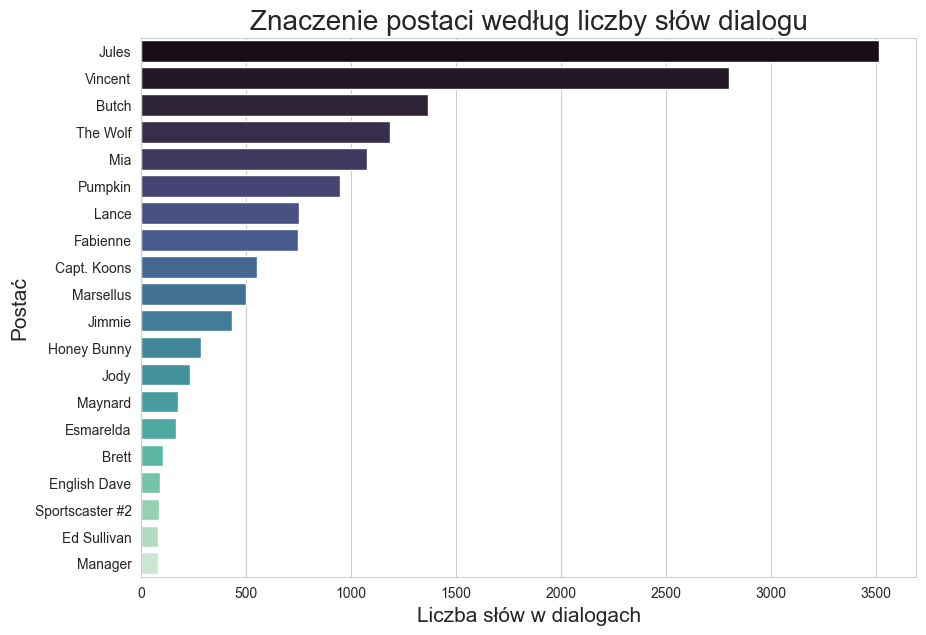

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='dialogue_wordcount',y='Character_name', data=total_char_words, palette="mako", order=total_char_words.sort_values('dialogue_wordcount', ascending=False).Character_name[0:20], orient='h')
plt.xlabel('Liczba słów w dialogach', fontsize=15)
plt.ylabel('Postać', fontsize=15)
plt.title('Znaczenie postaci według liczby słów dialogu', fontsize=20)

## Sprawdźmy teraz najczęściej występujące wyrazy ogólnie oraz w podziale na postać.

Dokonajmy teraz "czyszczenia" tekstu przy użyciu poniższej funkcji poprzez usuwanie wszelkich linków, liczb, symboli i słów stop (takich jak "the", "a" itp.). 

In [16]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [PorterStemmer().stem(w) for w in filtered_words]
    lemma_words=[WordNetLemmatizer().lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

### Najczęściej używane słowa ogółem.

In [18]:
title['cleanText']=title['Line'].map(lambda x:preprocess(x))

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/bartosch/nltk_data'
    - '/Users/bartosch/miniconda3/envs/3_11.venv/nltk_data'
    - '/Users/bartosch/miniconda3/envs/3_11.venv/share/nltk_data'
    - '/Users/bartosch/miniconda3/envs/3_11.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
common_words = Counter(" ".join(title["cleanText"]).split()).most_common(10)
common_words

[('fuckin', 91),
 ('gonna', 77),
 ('like', 76),
 ('know', 73),
 ('get', 70),
 ('one', 68),
 ('shit', 65),
 ('got', 64),
 ('man', 61),
 ('well', 49)]

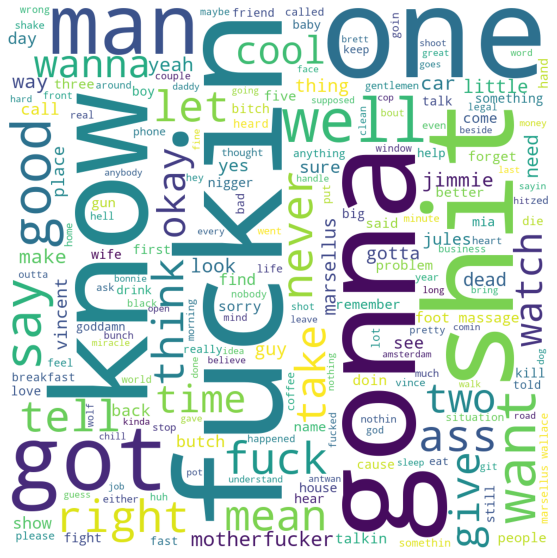

In [ ]:
text = " ".join(line for line in title["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Najczęściej używane słowa przez Jules'a

In [ ]:
jules = title[title['Character_name']=='Jules']

In [ ]:
common_jules = Counter(" ".join(jules["cleanText"]).split()).most_common(5)
common_jules

[('shit', 33), ('man', 22), ('like', 22), ('fuckin', 21), ('know', 17)]

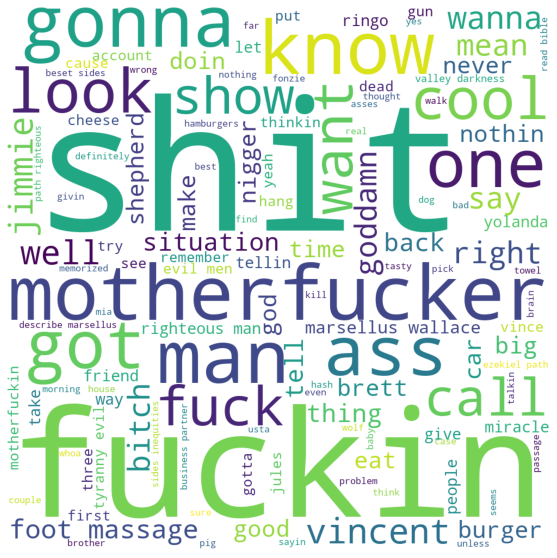

In [ ]:
jules_text = " ".join(line for line in jules["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(jules_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Najczęściej używane słowa przez Vincent'a

In [ ]:
vincent = title[title['Character_name']=='Vincent']

In [ ]:
common_vincent = Counter(" ".join(vincent["cleanText"]).split()).most_common(5)
common_vincent

[('fuckin', 24), ('know', 20), ('got', 15), ('like', 13), ('marsellus', 13)]

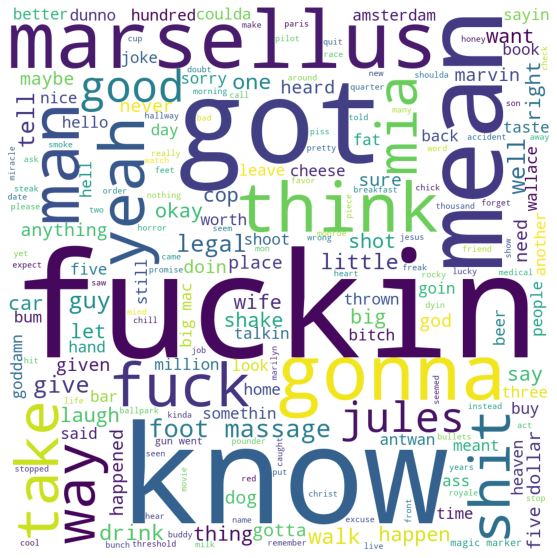

In [ ]:
vincent_text = " ".join(line for line in vincent["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(vincent_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Najczęściej używane słowa przez Butch'a

In [ ]:
butch = title[title['Character_name']=='Butch']

In [ ]:
common_butch = Counter(" ".join(butch["cleanText"]).split()).most_common(5)
common_butch

[('get', 9), ('watch', 9), ('sorry', 7), ('gonna', 7), ('dead', 6)]

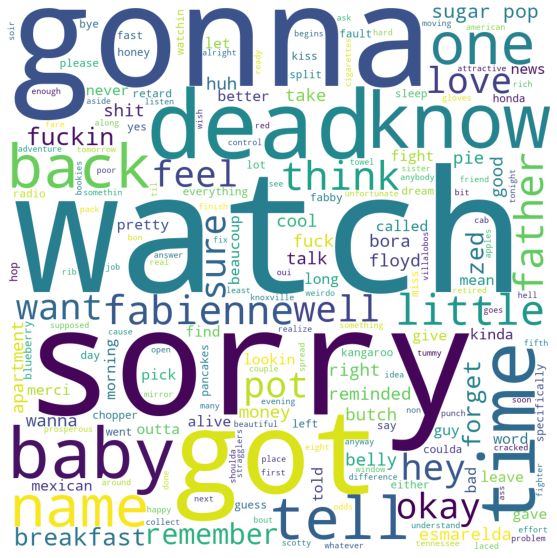

In [ ]:
butch_text = " ".join(line for line in butch["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(butch_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Analiza sentymentu

Analizę sentymentu chciałbym przeprowadzić na dwa sposoby.
Pierwszy to przy użyciu biblioteki nltk - SentimentIntensityAnalyzer.
Drugi przy użyciu datasetów znalezionych w internecie i budowie modelu predykcyjnego.

1. NLTK Sentiment Analyzer

In [ ]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
title["nltk_sentiment"] = title["cleanText"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
title.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count,dialogue_wordcount,cleanText,nltk_sentiment
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11,13,forget risky doin shit,-0.7430
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15,16,always say thing every time never dangerous,0.3724
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12,15,know always say always right,0.0000
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10,11,forget day two,-0.2263
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18,19,yeah well days forgittin days rememberin begun,0.5106


Teraz wyświetlmy pozytywne i negatywne dialogi

In [ ]:
positive_dialogues = title.sort_values("nltk_sentiment", ascending=False).head(5)
negative_dialogues = title.sort_values("nltk_sentiment", ascending=True).head(5)
positive_dialogues[["cleanText", "nltk_sentiment"]]

,cleanText,nltk_sentiment
975,set straight buster say please tell want self ...,0.9524
971,good need two fellas take cleaning products cl...,0.9510
1014,perfect perfect planned better guys look like ...,0.9360
597,tell soon word got fix odds would outta contro...,0.9313
916,used soap dried hands towel look like fuckin m...,0.9186


In [ ]:
negative_dialogues[["cleanText", "nltk_sentiment"]]

,cleanText,nltk_sentiment
1179,passage got memorized ezekiel path righteous m...,-0.9951
547,watch got first purchased great granddaddy bou...,-0.9834
1137,let let blow fuckin head kill kill gonna die g...,-0.9709
137,look give man foot massage make right marsellu...,-0.9674
259,nigger inglewood house white people know diffe...,-0.9638


Sentyment z podziałem na postacie

In [ ]:
sentiment_by_character = title.groupby("Character_name")["nltk_sentiment"].mean().sort_values(ascending=False)
sentiment_by_character

Character_name
Preacher (Emil Simkus)    0.636900
Raquel                    0.331300
Looky-loo woman           0.273200
Pedestrian                0.226300
Gawker #2                 0.190900
The Wolf                  0.171794
Mother                    0.133733
Ed Sullivan               0.124129
Brett                     0.115189
Zed                       0.048330
Fabienne                  0.045251
Mia                       0.043231
Butch                     0.038938
Pumpkin                   0.028471
Vincent                   0.008155
Honey Bunny               0.002885
Marvin                    0.000000
Waitress                  0.000000
The Gimp                  0.000000
Klondike                  0.000000
Roger                     0.000000
Jimmie                   -0.028869
Maynard                  -0.034662
Capt. Koons              -0.075100
Jules                    -0.079204
Lance                    -0.081794
Jody                     -0.096829
Buddy                    -0.101450
Engli

Średni sentyment z podziałem na lokacje

In [ ]:
sentiment_by_location = title.groupby("Place")["nltk_sentiment"].mean().sort_values(ascending=False)
sentiment_by_location

Place
ext. phone booth (raining)                   0.844600
int. kitchen                                 0.533727
int. Chevy Nova                              0.320067
int. bathroom (Marsellus Wallace's house)    0.309333
ext. Monster Joe's Truck and Tow             0.154160
int. Jimmie's garage                         0.151512
ext. motel (stopped / raining)               0.133317
ext. apartment building courtyard            0.120567
int. Chevy (trunk)                           0.105612
int. motel (room six)                        0.071315
int. Jackrabbit Slim's                       0.047945
int. Mason-Dixie pawnshop                    0.042190
int. Jackrabbit Slim's (dining area)         0.042166
int. Jimmie's house                          0.032938
living room                                  0.032344
int. '74 Chevy (moving)                      0.026320
int. Jimmie's bedroom                        0.024541
int. Sally LeRoy's                           0.013624
int. spare room       

Średni sentyment z podziałem na porę dnia.

In [ ]:
sentiment_by_time = title.groupby("Time")["nltk_sentiment"].mean().sort_values(ascending=False)
sentiment_by_time

Time
night     -0.002465
morning   -0.004760
day       -0.017863
Name: nltk_sentiment, dtype: float64

2. Przy pomocy modelu

Wytrenuję model określający sentyment każdej linii dialogowej z filmu korzystając z zewnętrznego zbioru danych. Użyty zestaw danych pochodzi Kaggle https://www.kaggle.com/kazanova/sentiment140
Jest to zbiór danych sentiment140. Zawiera on 1 600 000 tweetów wyodrębnionych za pomocą twitter api. Tweety zostały opatrzone adnotacjami (0 = negatywne, 4 = pozytywne) i mogą być z powodzeniem wykorzystywane do wykrywania nastrojów.

In [ ]:
# Ładujemy dane

twit_sent = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='cp1252', names = ['label', 'id', 'date', 'flag', 'user', 'text'])

In [ ]:
twit_sent.head()

,label,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# pozbywamy się niepotrzebnych kolumn

twit_sent = twit_sent.drop(['id', 'date', 'flag', 'user'], axis=1)

In [ ]:
# Zestaw zawiera 1,600,000 wierszy. To bardzo duży set. Wykorzystamy 10% zbioru.

twit_samp = twit_sent.sample(n=50000,replace=False)

In [ ]:
# tworzymy nową kolumnę cleantext przy pomocy wcześniej zdefiniowanej funkcji 

twit_samp['cleanText']=twit_samp['text'].map(lambda x:preprocess(x))

In [ ]:
# filtrowanie danych, aby po przetworzeniu używać tylko tweetów zawierających więcej niż dwa słowa

twit_samp['clean_wordcount'] = twit_samp['cleanText'].map(lambda x:len(re.findall(r'\w+', x)))
filtered_twit = twit_samp[twit_samp['clean_wordcount'] > 2]

In [ ]:
x_train_samp = filtered_twit['cleanText']
y_train_samp = filtered_twit['label']

In [ ]:
y_train_samp = y_train_samp.replace(4,1)

In [ ]:
# tworzenie zestawy - 90% trening, 10% walidacja

x_train_samp, x_valid_samp, y_train_samp, y_valid_samp = train_test_split(x_train_samp, y_train_samp, test_size=0.1)

In [ ]:
# konwertuje to słowa na wektory liczb, aby umożliwić ich użycie w modelach

tokenizer = RegexpTokenizer(r'\w+')
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(x_train_samp.values) + list(x_valid_samp.values)
vectorizer.fit(full_text)
train_vectorized_samp = vectorizer.transform(x_train_samp)
test_vectorized_samp = vectorizer.transform(x_valid_samp)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
title_vectorized = vectorizer.transform(title['cleanText'])

In [ ]:
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
logreg.fit(train_vectorized_samp, y_train_samp)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
logreg.score(test_vectorized_samp, y_valid_samp)

0.7596322241681261

In [ ]:
linsvc = LinearSVC(max_iter=2000)
linsvc.fit(train_vectorized_samp, y_train_samp)
linsvc.score(test_vectorized_samp, y_valid_samp)

0.7554728546409807

In [ ]:
multinb = MultinomialNB()
multinb.fit(train_vectorized_samp, y_train_samp)
multinb.score(test_vectorized_samp, y_valid_samp)

0.7469352014010507

In [ ]:
bernb = BernoulliNB()
bernb.fit(train_vectorized_samp, y_train_samp)
bernb.score(test_vectorized_samp, y_valid_samp)

0.7467162872154116

Confusion matrix

Confusion Matrix:
[[1705  590]
 [ 527 1746]]


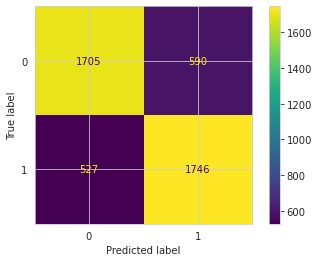

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt


predictions = linsvc.predict(test_vectorized_samp)

# Generate the confusion matrix
cm = confusion_matrix(y_valid_samp, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plot_confusion_matrix(linsvc, test_vectorized_samp, y_valid_samp)
plt.show()


Regresja logistyczna, jak i liniowy model SVC poradziły sobie nieźle, z dokładnością około 76%. Aby osiągnąć wyższą dokładność, do wytrenowania modelu można wykorzystać większą próbkę i spróbować użyć sieci neuronowej. Niestety czas potrzebny do obliczeń na moim komputerze jest dla mnie problemem i dlatego pomimo prób nie skorzystałem z tej opcji. 

Użyję modelu regresji logistycznej, aby oznaczyć każdą linię dialogu jako 0 (negatywną) lub 1 (pozytywną).

In [ ]:
preds = logreg.predict(title_vectorized)

In [ ]:
title['sentiment_preds'] = preds

In [ ]:
title.head()

,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count,dialogue_wordcount,cleanText,nltk_sentiment,sentiment_preds
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11,13,forget risky doin shit,-0.7430,0
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15,16,always say thing every time never dangerous,0.3724,0
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12,15,know always say always right,0.0000,1
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10,11,forget day two,-0.2263,1
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18,19,yeah well days forgittin days rememberin begun,0.5106,1


Dane powinny zostać przefiltrowane, zanim przejdziemy dalej. Trudno jest określić prawidłowy sentyment na podstawie bardzo niewielu słów, dlatego nie możemy ufać tym etykietom, więc w dalszej analizie uwzględnię tylko przetworzony tekst zawierający więcej niż dwa słowa.



In [ ]:
title['clean_wordcount'] = title['cleanText'].map(lambda x:len(re.findall(r'\w+', x)))
filtered_title = title[title['clean_wordcount'] > 2]
filtered_title.head()

,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count,dialogue_wordcount,cleanText,nltk_sentiment,sentiment_preds,clean_wordcount
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11,13,forget risky doin shit,-0.7430,0,4
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15,16,always say thing every time never dangerous,0.3724,0,7
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12,15,know always say always right,0.0000,1,5
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10,11,forget day two,-0.2263,1,3
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18,19,yeah well days forgittin days rememberin begun,0.5106,1,7


In [ ]:
# chcemy dokonać dalszej filtracji, dlatego weźmiemy tylko top 10 postaci z największą ilością line's

char_counts = filtered_title['Character_name'].value_counts()
char_counts = char_counts[0:10]
char_counts = pd.DataFrame(char_counts)
char_counts['count'] = char_counts['Character_name']
char_counts['Character_name'] = char_counts.index
char_counts = char_counts.reset_index()
char_counts.drop('index', axis=1)

,Character_name,count
0,Jules,145
1,Vincent,133
2,Butch,74
3,The Wolf,45
4,Mia,44
5,Pumpkin,40
6,Fabienne,33
7,Lance,32
8,Honey Bunny,18
9,Marsellus,15


In [ ]:
filtered_title = filtered_title[filtered_title.Character_name.isin(char_counts['Character_name'])]

In [ ]:
filtered_title.head()

,Line number,character_in_script,Character_name,Off screen,Voice-over,Place,Time,Line,Word count,dialogue_wordcount,cleanText,nltk_sentiment,sentiment_preds,clean_wordcount
0,1,Young man,Pumpkin,False,False,int. coffee shop,morning,"No, forget it, it's too risky. I'm through doi...",11,13,forget risky doin shit,-0.7430,0,4
1,2,Young woman,Honey Bunny,False,False,int. coffee shop,morning,"You always say that, the same thing every time...",15,16,always say thing every time never dangerous,0.3724,0,7
2,3,Young man,Pumpkin,False,False,int. coffee shop,morning,I know that's what I always say. I'm always ri...,12,15,know always say always right,0.0000,1,5
3,4,Young woman,Honey Bunny,False,False,int. coffee shop,morning,â€“ but you forget about it in a day or two -,10,11,forget day two,-0.2263,1,3
4,5,Young man,Pumpkin,False,False,int. coffee shop,morning,"â€“ yeah, well, the days of me forgittin' are ...",18,19,yeah well days forgittin days rememberin begun,0.5106,1,7


Teraz obliczę średnie nastroje każdej z 10 najlepszych postaci, aby określić, które postacie są najbardziej pozytywne, a które najbardziej negatywne.

In [ ]:
pos_neg_char = filtered_title.groupby('Character_name', as_index=False).sentiment_preds.mean()
pos_neg_char= pd.DataFrame(pos_neg_char)
pos_neg_char

,Character_name,sentiment_preds
0,Butch,0.500000
1,Fabienne,0.575758
2,Honey Bunny,0.277778
3,Jules,0.496552
4,Lance,0.281250
5,Marsellus,0.600000
6,Mia,0.568182
7,Pumpkin,0.450000
8,The Wolf,0.444444
9,Vincent,0.496241


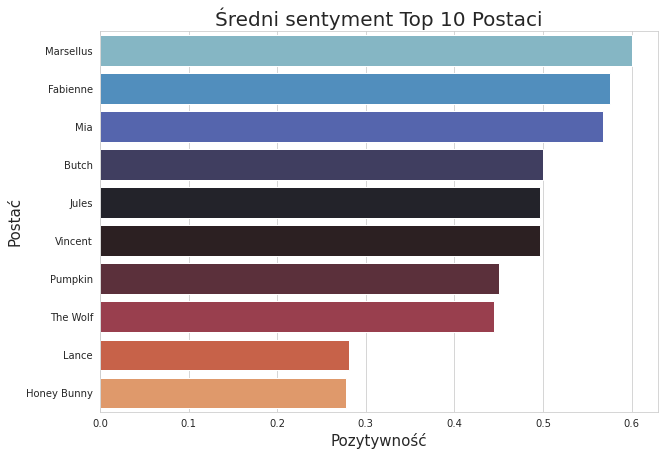

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x='sentiment_preds', y='Character_name', data=pos_neg_char, palette="icefire", order=pos_neg_char.sort_values('sentiment_preds', ascending=False).Character_name[0:10], orient='h')
plt.xlabel('Pozytywność', fontsize=15)
plt.ylabel('Postać', fontsize=15)
plt.title('Średni sentyment Top 10 Postaci', fontsize=20)
plt.show()

Możemy również na podstawie sentymentu  dialogów spróbować określić sentyment dla miejsca i pory dnia.

In [ ]:
pos_neg_time = filtered_title.groupby('Time', as_index=False).sentiment_preds.mean()
pos_neg_time= pd.DataFrame(pos_neg_time)
pos_neg_time

,Time,sentiment_preds
0,day,0.485714
1,morning,0.490196
2,night,0.470588


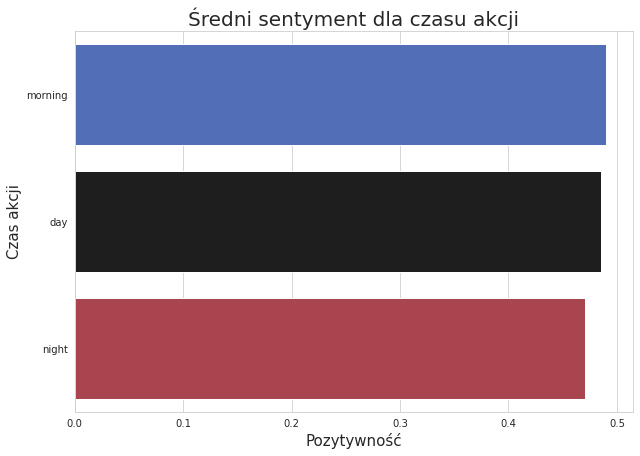

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x='sentiment_preds', y='Time', data=pos_neg_time, palette="icefire", order=pos_neg_time.sort_values('sentiment_preds', ascending=False).Time[0:3], orient='h')
plt.xlabel('Pozytywność', fontsize=15)
plt.ylabel('Czas akcji', fontsize=15)
plt.title('Średni sentyment dla czasu akcji', fontsize=20)
plt.show()

In [ ]:
pos_neg_place = filtered_title.groupby('Place', as_index=False).sentiment_preds.mean()
pos_neg_place= pd.DataFrame(pos_neg_place)
pos_neg_place

,Place,sentiment_preds
0,ext. Jackrabbit Slim's,0.666667
1,ext. Jimmie's backyard,0.571429
2,ext. Lance's house,0.250000
3,ext. Marsellus Wallace's house,0.000000
4,ext. Monster Joe's Truck and Tow,0.500000
5,ext. apartment building courtyard,0.500000
6,ext. front of Marsellus Wallace's house,0.375000
7,ext. motel (stopped / raining),1.000000
8,ext. motel room,0.500000
9,ext. phone booth (raining),1.000000


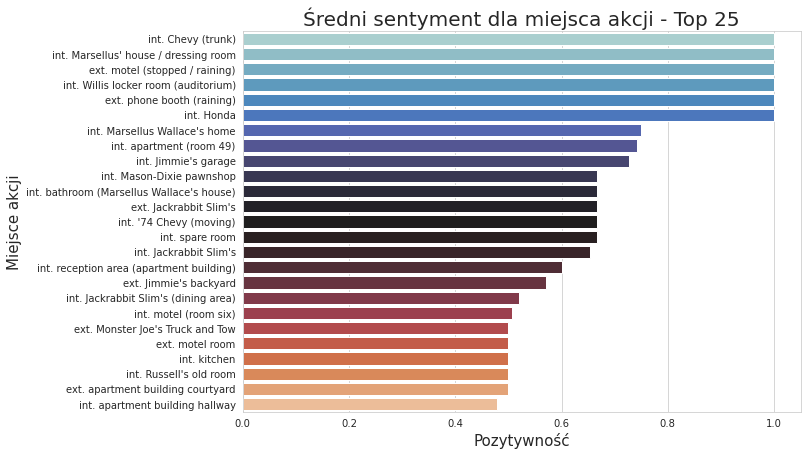

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x='sentiment_preds', y='Place', data=pos_neg_place, palette="icefire", order=pos_neg_place.sort_values('sentiment_preds', ascending=False).Place[0:25], orient='h')
plt.xlabel('Pozytywność', fontsize=15)
plt.ylabel('Miejsce akcji', fontsize=15)
plt.title('Średni sentyment dla miejsca akcji - Top 25', fontsize=20)
plt.show()

Według tego wykresu najbardziej pozytywnymi po filtracji postaciami są Mia, Fabienne i The Wolf z pozytywnością powyżej 50%. 
Najbardziej negatywnymi postaciami są Honey Bunny, Lance i Butch. 6 postaci z przefiltrowanych ma mniej niż 50% pozytywnego wydźwięku.



Możemy jeszcze spróbować wykręslić sentyment w czasie po numerach dialogów. Lepsza byłoby użycie timecode ale niestety nie mamy tych danych. 

In [ ]:
title['Line number']

0          1
1          2
2          3
3          4
4          5
        ... 
1178    1179
1179    1180
1180    1181
1181    1182
1182    1183
Name: Line number, Length: 1183, dtype: int64

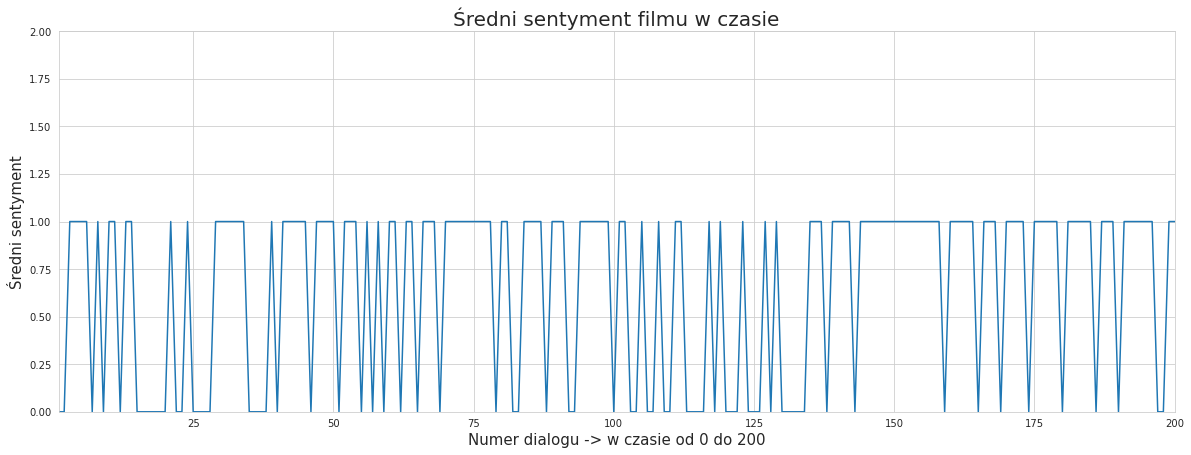

In [ ]:
scene_sent = pd.DataFrame(title.groupby('Line number', as_index=False).sentiment_preds.mean())
plt.figure(figsize=(20,7))
sns.lineplot(x="Line number", y="sentiment_preds", data=scene_sent)
plt.xlabel('Numer dialogu -> w czasie od 0 do 200', fontsize=15)
plt.ylabel('Średni sentyment', fontsize=15)
plt.title('Średni sentyment filmu w czasie', fontsize=20)
plt.ylim(0,2)
plt.xlim(1,200)
plt.show()

Jak widzimy, reżyser funduje nam niezłą jazdę przez cały czas trwania filmu. Pełne spektrum emocji od początku do końca!!!

## A mówiąc o emocjach, spróbujmy je także przeanalizować.

Ponownie skorzystamy z zewnętrznego setu danych. W tej części wykorzystam  zbiór danych, który również składa się z tweetów, ale zamiast etykiet sentymentu 0 lub 1, zawiera 13 emocji. https://www.kaggle.com/icw123/emotion

In [ ]:
emotions = pd.read_csv('/kaggle/input/emotion/text_emotion.csv')
emotions = emotions.drop(columns = ['tweet_id', 'author'])
emotions.groupby('sentiment').count()

,content
sentiment,
anger,110
boredom,179
empty,827
enthusiasm,759
fun,1776
happiness,5209
hate,1323
love,3842
neutral,8638


In [ ]:
# wyrzucamy anger i boredom bo jest ich za mało w porównaniu do reszty

emotions = emotions[emotions.sentiment.isin({'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry'})]

In [ ]:
# konwersja emocji do integer

emotions['sentiment'] = emotions['sentiment'].map({'empty':0, 'enthusiasm':1, 'fun':2, 'happiness':3, 'hate':4, 'love':5, 'neutral':6, 'relief':7, 'sadness':8, 'surprise':9, 'worry':10})
emotions.head()

,sentiment,content
0,0,@tiffanylue i know i was listenin to bad habi...
1,8,Layin n bed with a headache ughhhh...waitin o...
2,8,Funeral ceremony...gloomy friday...
3,1,wants to hang out with friends SOON!
4,6,@dannycastillo We want to trade with someone w...


In [ ]:
# czyścimy tekst przy pomocy predefiniowanej funkcji
emotions['cleanText']=emotions['content'].map(lambda x:preprocess(x))

In [ ]:
emotions.head()

,sentiment,content,cleanText
0,0,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,8,Layin n bed with a headache ughhhh...waitin o...,layin bed headache ughhhh waitin call
2,8,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1,wants to hang out with friends SOON!,wants hang friends soon
4,6,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone houston ticke...


In [ ]:
x_train2 = emotions['cleanText']
y_train2 = emotions['sentiment']

In [ ]:
x_vectorized = vectorizer.transform(x_train2)

Ponieważ dane są niezbalansowane (759 entuzjastycznych tweetów vs 8638 neutralnych), może to negatywnie wpłynąć na trenowanie modelu. Użyjemy SMOTE do ponownego próbkowania danych, aby każda emocja miała taką samą liczbę tweetów.

In [ ]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_vectorized, y_train2)

In [ ]:
train2_vectorized, test2_vectorized, y_train2, y_valid2 = train_test_split(x_smote, y_smote, test_size=0.1)

In [ ]:
logreg2 = LogisticRegression(max_iter=500)
logreg2.fit(train2_vectorized, y_train2)
logreg2.score(test2_vectorized, y_valid2)

0.5716691222900442

In [ ]:
linsvc2 = LinearSVC(max_iter=800)
linsvc2.fit(train2_vectorized, y_train2)
linsvc2.score(test2_vectorized, y_valid2)

0.708903388760261

In [ ]:
multinb2 = MultinomialNB()
multinb2.fit(train2_vectorized, y_train2)
multinb2.score(test2_vectorized, y_valid2)

0.5951378657124816

Jak widzimy Linear SVC uzyskało najwyższy wynik.

Confusion Matrix

Confusion Matrix:
[[867   1   3   9   0   2   4   0   0   1   0]
 [ 39 773   1   4   1   0   0   3   0   2   0]
 [ 43   5 778  19   3   5   7   4   3   6   5]
 [ 56  23  50 474   9  63  61  36  22  25  28]
 [ 35   1   1   0 816   1   1   1   0   2   0]
 [ 51  14  17  53   5 647  27  20  11  14  14]
 [ 57  50  63  86  46  71 169  55  74  65 132]
 [ 35   2   2  10   2   3   6 825   2   1   0]
 [ 73  10  17  23  45  25  60  24 457  34 104]
 [ 40  11   7  11   8  18  14   8   9 676   8]
 [ 44  31  35  58  57  54 113  43 142  67 254]]


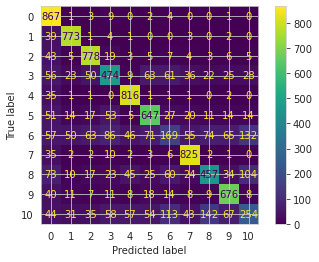

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt


predictions = linsvc2.predict(test2_vectorized)

# Generate the confusion matrix
cm = confusion_matrix(y_valid2, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plot_confusion_matrix(linsvc2, test2_vectorized, y_valid2)
plt.show()


In [ ]:
preds2 = linsvc2.predict(title_vectorized)

In [ ]:
title['emotion_preds'] = preds2

In [ ]:
title['emotion_preds'] = title['emotion_preds'].map({0:'empty', 1:'enthusiasm', 2:'fun', 3:'happiness', 4:'hate', 5:'love', 6:'neutral', 7:'relief', 8:'sadness', 9:'surprise', 10:'worry'})

In [ ]:
title.rename(columns={'Line number': 'line_number'}, inplace=True)

In [ ]:
total_emotions = pd.DataFrame(title.groupby('emotion_preds', as_index=False).line_number.count())
total_emotions = total_emotions.sort_values('line_number', ascending=False)
total_emotions

,emotion_preds,line_number
6,neutral,194
10,worry,178
0,empty,170
4,hate,137
8,sadness,106
9,surprise,102
3,happiness,79
1,enthusiasm,63
2,fun,54
5,love,53


Text(0, 0.5, 'Emocja')

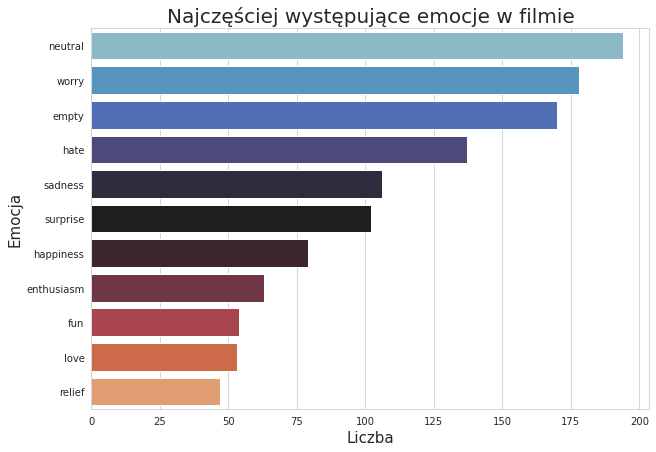

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='line_number', data=total_emotions, palette="icefire", orient='h')
plt.title('Najczęściej występujące emocje w filmie', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocja', fontsize=15)

Neutralność i zmartwienie to dwie najczęstsze emocje w filmie, podczas gdy miłość i ulga są najmniej powszechne. W zestawie treningowym te emocje były w połowie stawki jeżeli chodzi o liczebność,
Natomiast neutral i worry były najliczniejsze w zsetawie treningowym, więc wyniki te mogą nie być dokładne i mogą być wynikiem niezrównoważenia zestawu danych, pomimo użycia SMOTE. Jednak znając ten film mogę uznać, że wyniki całkiem nieźle go opisują jeżeli chodzi o liczebność emocji.

### Most common emotions of some of the main characters

Text(0, 0.5, 'Emocje')

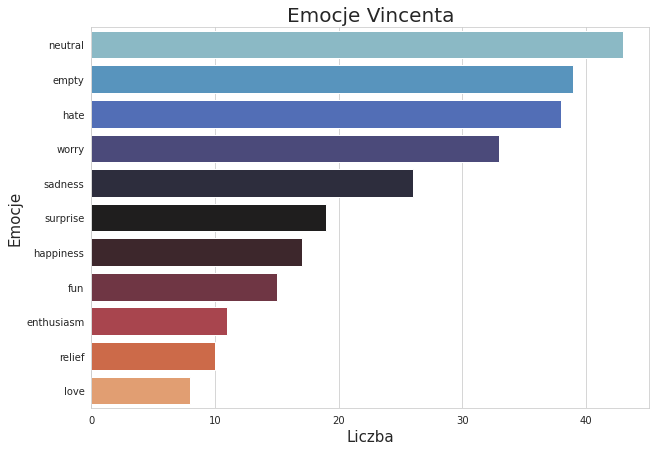

In [ ]:
char_emotions = pd.DataFrame(title.groupby('Character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['Character_name']=='Vincent'], palette='icefire')
plt.title('Emocje Vincenta', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocje', fontsize=15)

Text(0, 0.5, 'Emocje')

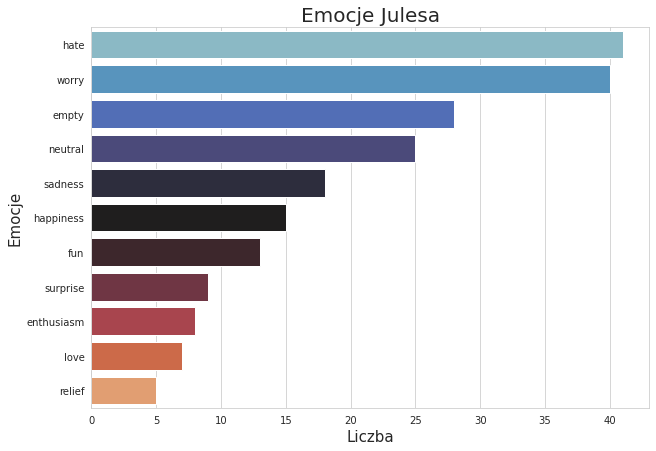

In [ ]:
char_emotions = pd.DataFrame(title.groupby('Character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['Character_name']=='Jules'], palette='icefire')
plt.title('Emocje Julesa', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocje', fontsize=15)

Text(0, 0.5, 'Emocje')

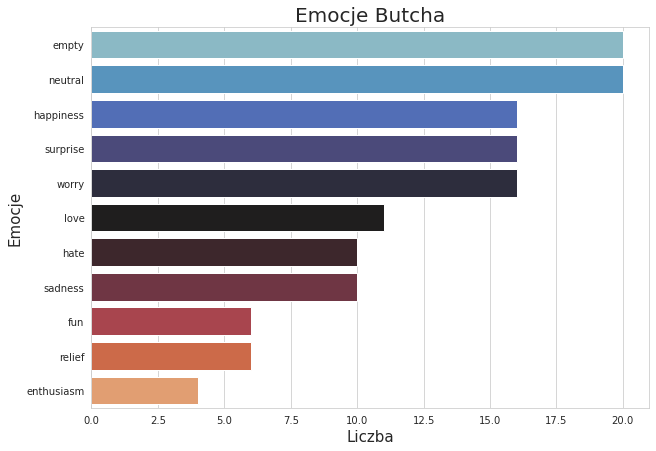

In [ ]:
char_emotions = pd.DataFrame(title.groupby('Character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['Character_name']=='Butch'], palette='icefire')
plt.title('Emocje Butcha', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocje', fontsize=15)

Text(0, 0.5, 'Emocje')

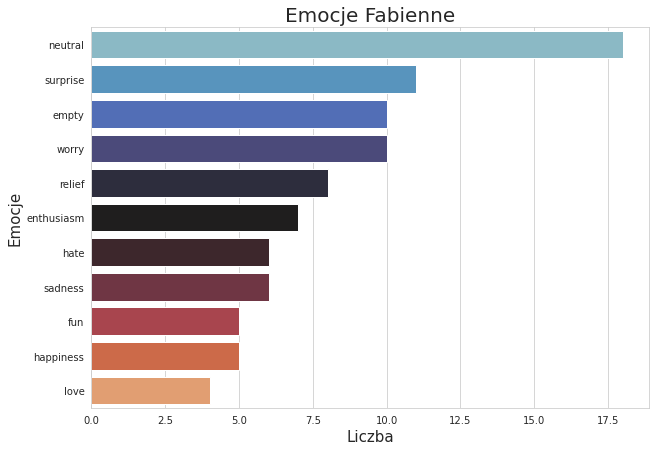

In [ ]:
char_emotions = pd.DataFrame(title.groupby('Character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['Character_name']=='Fabienne'], palette='icefire')
plt.title('Emocje Fabienne', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocje', fontsize=15)

Text(0, 0.5, 'Emocje')

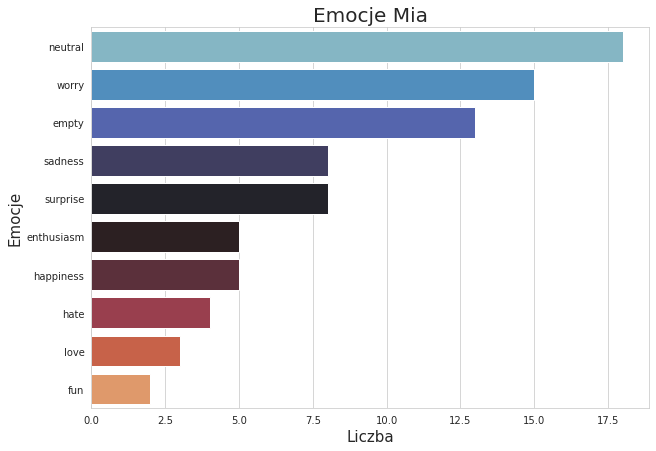

In [ ]:
char_emotions = pd.DataFrame(title.groupby('Character_name').emotion_preds.value_counts())
char_emotions = char_emotions.rename(columns={'emotion_preds': 'counts'})
char_emotions = char_emotions.reset_index()
plt.figure(figsize=(10,7))
sns.barplot(y='emotion_preds', x='counts', data=char_emotions[char_emotions['Character_name']=='Mia'], palette='icefire')
plt.title('Emocje Mia', fontsize=20)
plt.xlabel('Liczba', fontsize=15)
plt.ylabel('Emocje', fontsize=15)

Myślę, że posortowane emocje poszczególnych postaci całkiem dobrze oddają ich charakter na ekranie.

### Chcemy może poszukać jakiegoś konkretnego słowa w dialogach?

In [ ]:
word = "shit" 

In [ ]:
def simple_line_finder(title, word):
  for index, row in title.iterrows():
    line = str(row["Line"])
    line_number = row["line_number"]
    if word.lower() in line.lower():
      print(f"Line {line_number}: {line}")
 
simple_line_finder(title, word)

Line 1: No, forget it, it's too risky. I'm through doin' that shit.
Line 65: It's the little differences. A lotta the same shit we got here, they got there, but there they're a little different.
Line 124: It ain't no ballpark either. Look maybe your method of massage differs from mine, but touchin' his lady's feet, and stickin' your tongue in her holyiest of holyies, ain't the same ballpark, ain't the same league, ain't even the same fuckin' sport. Foot massages don't mean shit.
Line 128: Shit yeah. I got my technique down man, I don't tickle or nothin'.
Line 139: I'm not sayin' he was right, but you're sayin' a foot massage don't mean nothing, and I'm sayin' it does. I've given a million ladies a million foot massages and they all meant somethin'. We act like they don't, but they do. That's what's so fuckin' cool about 'em. This sensual thing's goin' on that nobody's talkin about, but you know it and she knows it, fuckin' Marsellus knew it, and Antwan shoulda known fuckin' better. Tha

In [ ]:
words = ["yes", "shit"]  # lub poszukajmy samych nr linii (w idealnej opcji byłby to timecode dialogu)

In [ ]:
def find_multiple_words_in_lines(title, words):
  line_numbers = {}
  for index, row in title.iterrows():
    line = str(row["Line"])
    line_number = row["line_number"]
    for word in words:
      if word.lower() in line.lower():
        if word not in line_numbers:
          line_numbers[word] = [line_number]
        else:
          line_numbers[word].append(line_number)
  return line_numbers

line_numbers = find_multiple_words_in_lines(title, words)
line_numbers

{'shit': [1,
  65,
  124,
  128,
  139,
  186,
  196,
  224,
  225,
  258,
  260,
  265,
  277,
  280,
  360,
  362,
  459,
  494,
  594,
  732,
  758,
  815,
  858,
  864,
  865,
  866,
  891,
  897,
  904,
  909,
  910,
  917,
  919,
  922,
  930,
  933,
  935,
  936,
  942,
  970,
  972,
  990,
  992,
  1002,
  1019,
  1022,
  1055,
  1071,
  1087,
  1093,
  1116,
  1160,
  1165,
  1180],
 'yes': [13,
  45,
  98,
  205,
  207,
  221,
  222,
  553,
  555,
  629,
  631,
  671,
  717,
  724,
  726,
  728,
  846,
  871,
  960,
  1006,
  1058,
  1121]}

## Dla fun'u zróbmy prosty generator dialogów i chatbota w oparciu o randomowe dialogi z filmu

Czasem jak już jest źle i nie ma się kompletnie pomysłu można skorzystać z:

In [ ]:
import random
# Extract the lines from the dataset
lines = title["Line"].tolist()
def generate_dialogue(num_lines):
  dialogue = []
  for _ in range(num_lines):
    random_line = random.choice(lines)
    dialogue.append(random_line)
  return "\n".join(dialogue)
# Generate a dialogue with 5 lines
generated_dialogue = generate_dialogue(5)
# laduje model
nlp = spacy.load("en_core_web_sm")

# przypisanie
text = generated_dialogue

# Procesuje text z  modelem
doc = nlp(text)

# Vizka
displacy.render(doc, style="ent", jupyter=True)


albo z prostego chata:

In [ ]:
user_input = "How are you?"

In [ ]:
import random
# Extract the lines from the dataset
lines = title["Line"].tolist()
def chatbot_response(user_input):
  response = random.choice(lines)
  return response
# Example usage of the chatbot
#user_input = "fuck you?"
response = chatbot_response(user_input)
response

'You said you waited for me?'

In [ ]:
import random
# Extract linii z dataset
lines = title["Line"].tolist()
def chatbot_response(user_input):
  response = random.choice(lines)
  return response

#user input
response = chatbot_response(user_input)


# laduje model
nlp = spacy.load("en_core_web_sm")

# przypisanie
text = response

# Procesuje text z  modelem
doc = nlp(text)

# Vizka
displacy.render(doc, style="ent", jupyter=True)


/opt/conda/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)
